In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [1]:
spark = SparkSession.builder.appName('plot').getOrCreate()

In [2]:
from io import StringIO
import itertools
import numpy as np
import pandas as pd
from pandas import Series
from pandas import concat
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(40,10))
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

<Figure size 2880x720 with 0 Axes>

In [3]:
%%time
def readFiles (feature):
    def process(tup):
        def convertTuple(tup): 
            str =  ''.join(tup) 
            return str

        # Driver code 
        str = convertTuple(tup[0:2]) 
        df = pd.read_csv(StringIO(str), header=None)

        # slicing the output and storing filename in "filename dataframe"
        filename = df[0:1]
        filename = filename.iloc[0][0].replace('txtncols         180','')
        filename = filename[-9:-1]

        # storing the content of file in "content dataframe"
        content = df[6:]

        counter = 0 
        allValues = 0

        # iterate through all the rows and columns of the file - better than for loop which took 40 mins
        modPandasDF=content.iloc[:,0].str.split(' ',expand=True).replace("-9999",float('NaN'))
        modPandasDF=modPandasDF.astype('float')
        modPandasDF=modPandasDF.values
        xDF=np.nanmean(modPandasDF)
        mean=np.nanmean(xDF)

        return filename, mean
    
    # daily grid data for rainfall
    if(feature=="rainfall" or feature=="maximum-temperature"):
        path = "hdfs:/data/HCP053/climate/gridded-land-obs-daily/grid/"+feature+"/*"
    elif(feature=="sunshine" or feature=="snow-falling"):
        path = "hdfs:/data/HCP053/climate/gridded-land-obs-monthly/"+feature+"/*"

    # Get rdd containing one record for each file.
    files_rdd = sc.wholeTextFiles(path, minPartitions=20)
    print(type(files_rdd))

    print('Number of records (months):', files_rdd.count())
    print('Number of partitions:', files_rdd.getNumPartitions())

    # map lines to n_words
    records = files_rdd.map(lambda n : process(n))

    # collect the RDD to a list
    llist = records.collect()

    # two arrays
    values = []
    months = []

    # store the filename in months array and its corrosponding value(mean) in values array
    for line in llist:
        values.append(line[1])
        months.append(line[0])

    # converting arrays to dataframes
    valuesdf = pd.DataFrame({'DailyMean':values[:]})
    yearmonthdf = pd.DataFrame({'YearMonth':months[:]})

    # merging two dataframes into one
    finaldf = pd.merge(yearmonthdf, valuesdf, left_index=True, right_index=True)

    # sort the index
    finaldf = finaldf.sort_values('YearMonth')

    # converting first column to integer format
    finaldf['YearMonth'] = finaldf['YearMonth'].astype('int')

    # converting first column from integer to datetime format
    finaldf['YearMonth'] = pd.to_datetime(finaldf['YearMonth'].astype(str), format='%Y%m%d')

    # extracting year and month 
    finaldf['Year'] = finaldf['YearMonth'].dt.year
    finaldf['Month'] = finaldf['YearMonth'].dt.month

    print(finaldf.head())
    
    return finaldf

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


<class 'pyspark.rdd.RDD'>
Number of records (months): 20820
Number of partitions: 20
      YearMonth  DailyMean  Year  Month
5211 1960-01-01   8.512501  1960      1
1042 1960-01-02   6.546298  1960      1
1043 1960-01-03   9.643672  1960      1
7296 1960-01-04   9.820417  1960      1
1044 1960-01-05   6.669331  1960      1


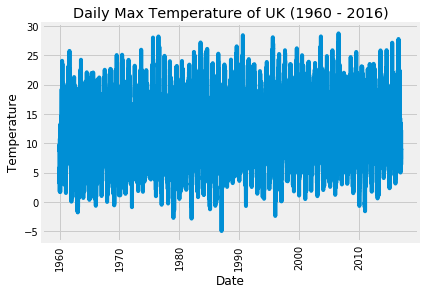

CPU times: user 598 ms, sys: 21.3 ms, total: 620 ms
Wall time: 4min 6s


In [5]:
%%time

finaldf = readFiles("maximum-temperature")

# general plot for annual max temp data

plt.plot(finaldf.YearMonth, finaldf.DailyMean)
plt.title('Daily Max Temperature of UK (1960 - 2016)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.xticks(rotation='vertical')
plt.show()
z=pd.DataFrame(finaldf['YearMonth'])
z.insert(1,'DailyMean',finaldf['DailyMean'])
z.to_csv('SGW1.csv', index=False)
# Observation from plot: just plotting temp vs years makes no sense as it is not possible to observe any trends

In [6]:
print(finaldf.dtypes)
print(finaldf.head())

YearMonth    datetime64[ns]
DailyMean           float64
Year                  int64
Month                 int64
dtype: object
      YearMonth  DailyMean  Year  Month
5211 1960-01-01   8.512501  1960      1
1042 1960-01-02   6.546298  1960      1
1043 1960-01-03   9.643672  1960      1
7296 1960-01-04   9.820417  1960      1
1044 1960-01-05   6.669331  1960      1


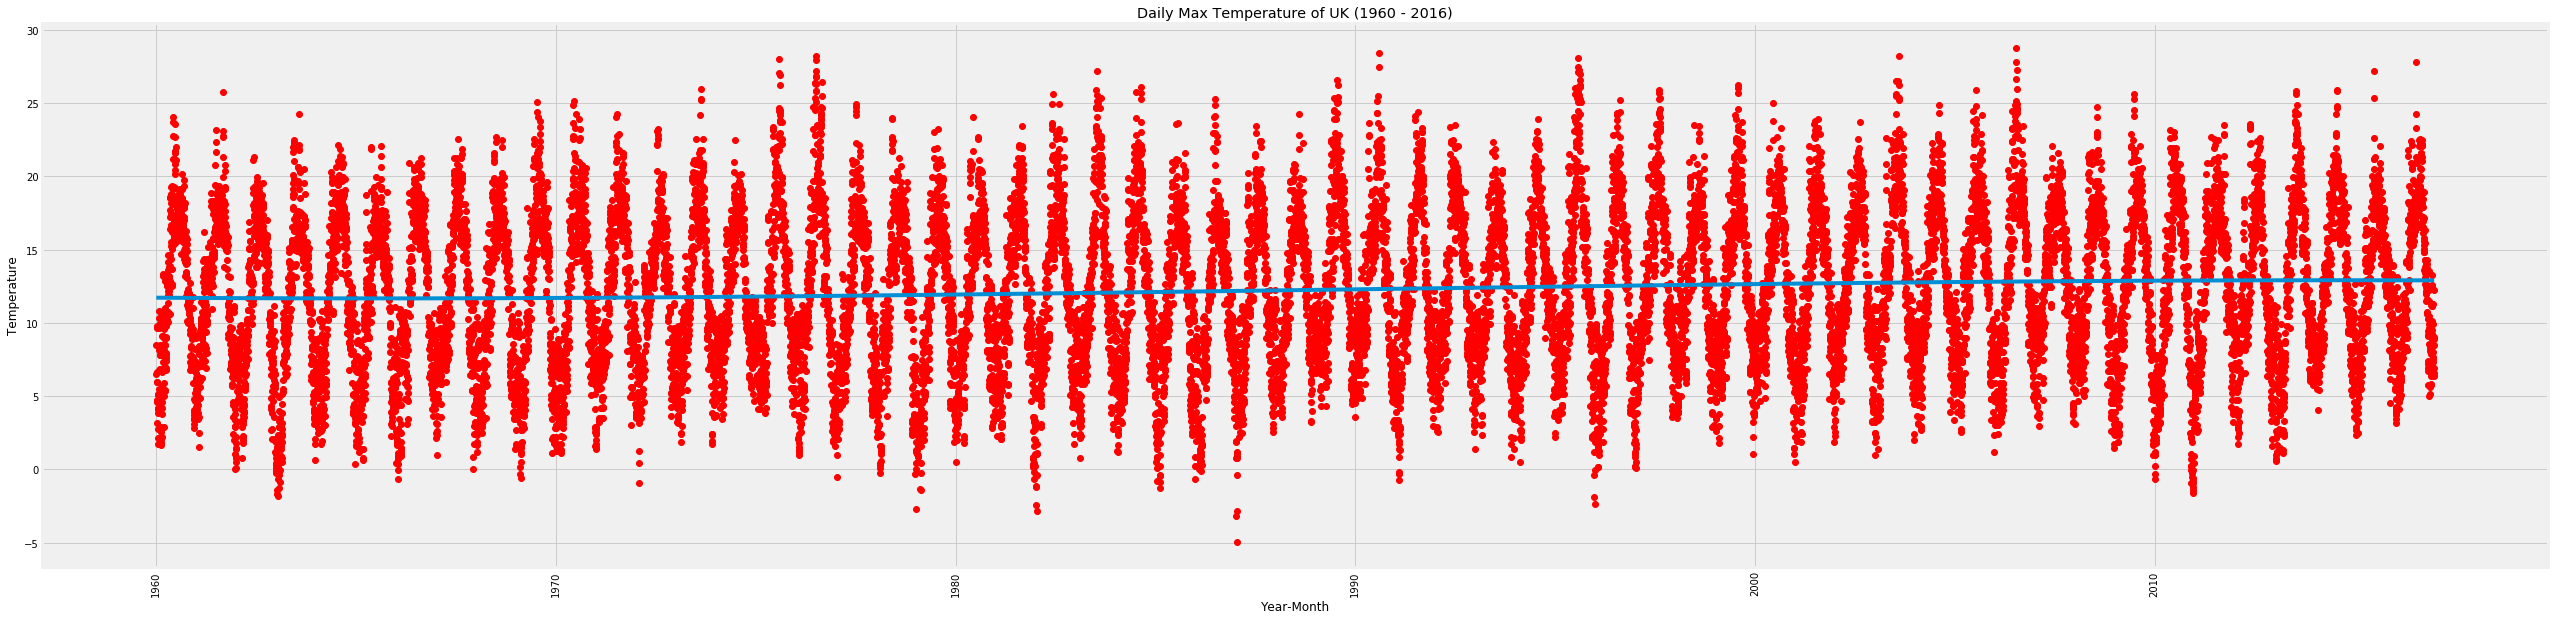

In [34]:
# BEST LINE FIT to look for any trend in data if present
y_values = finaldf['DailyMean']

#create a set of intervals equal to the number of dates
x_values = np.linspace(0,1,len(finaldf.loc[:, "DailyMean"]))
poly_degree = 3

coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(x_values)
fig = plt.figure(figsize=(40,10))
plt.xlabel('Year-Month')
plt.title('Daily Max Temperature of UK (1960 - 2016)')
plt.ylabel('Temperature')
plt.xticks(rotation='vertical')
plt.plot(finaldf.loc[:, "YearMonth"], finaldf.loc[:,"DailyMean"], "ro")
plt.plot(finaldf.loc[:, "YearMonth"], y_hat)
y=pd.DataFrame(y_hat)
y.insert(1,'Year',finaldf['YearMonth'])
y.to_csv('SGW2.csv', index=False)
# it can be seen from the plot, the slope of best line fit is almost zero entirely
# hence it is not ideal to consider temperature as the deciding factor to prove summer is getting warmer

In [8]:
# creating a backup(tempdf) of finaldf
tempdf = finaldf
tempdf.head()

,YearMonth,DailyMean,Year,Month
5211,1960-01-01,8.512501,1960,1
1042,1960-01-02,6.546298,1960,1
1043,1960-01-03,9.643672,1960,1
7296,1960-01-04,9.820417,1960,1
1044,1960-01-05,6.669331,1960,1


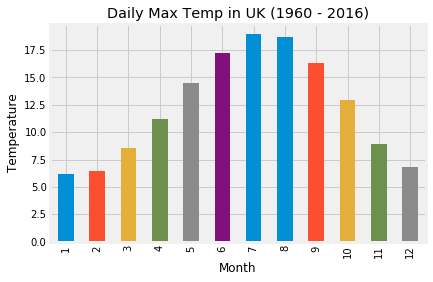

In [9]:
# plotting max temp on monthly basis

maxtempdf = tempdf.loc[tempdf['Month'].isin(['1','2','3','4','5','6','7','8','9','10','11','12'])]
plt.xlabel('Months')
plt.title('Daily Max Temp in UK (1960 - 2016)')
plt.ylabel('Temperature')
maxtempdf.groupby('Month')['DailyMean'].mean().plot.bar()

# we can observe the temperature during summers is higher than other seasons (as expected)

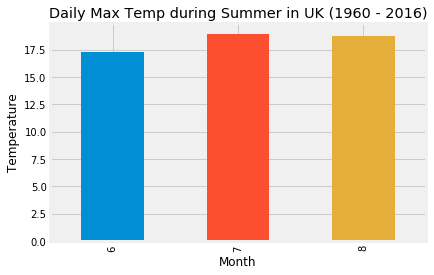

In [10]:
# plotting max temp for months of summer

maxtempdf = tempdf.loc[tempdf['Month'].isin(['6','7','8'])]
plt.xlabel('Months')
plt.title('Daily Max Temp during Summer in UK (1960 - 2016)')
plt.ylabel('Temperature')
maxtempdf.groupby('Month')['DailyMean'].mean().plot.bar()

In [11]:
maxtempdf.head(10)

,YearMonth,DailyMean,Year,Month
1054,1960-06-01,19.134994,1960,6
1055,1960-06-02,21.189111,1960,6
13574,1960-06-03,22.783049,1960,6
3137,1960-06-04,23.720832,1960,6
2095,1960-06-05,24.084873,1960,6
6265,1960-06-06,19.275133,1960,6
1056,1960-06-07,16.492760,1960,6
13575,1960-06-08,15.982431,1960,6
13576,1960-06-09,15.431055,1960,6
11,1960-06-10,15.852766,1960,6


In [12]:
# to prove summer is getting warmer, we consider counting number of days in summer (or a year) having temperature more than 18 degree
# if this number keeps on increasing, it could be said that, 
# "Number of days having above average(>18) temperature are increasing during summer"

# dataframe to hold number of days having temperature more than 18 degree
daysabovethresholdtemp = maxtempdf.loc[(maxtempdf['DailyMean'] >= 18)]

In [13]:
print(daysabovethresholdtemp.dtypes)
print(daysabovethresholdtemp.head(10))

YearMonth    datetime64[ns]
DailyMean           float64
Year                  int64
Month                 int64
dtype: object
       YearMonth  DailyMean  Year  Month
1054  1960-06-01  19.134994  1960      6
1055  1960-06-02  21.189111  1960      6
13574 1960-06-03  22.783049  1960      6
3137  1960-06-04  23.720832  1960      6
2095  1960-06-05  24.084873  1960      6
6265  1960-06-06  19.275133  1960      6
13578 1960-06-15  18.142552  1960      6
10428 1960-06-16  19.241085  1960      6
13579 1960-06-17  21.649957  1960      6
1058  1960-06-18  21.755903  1960      6


(array([711858., 715510., 719163., 722815., 726468., 730120., 733773.,
        737425.]), <a list of 8 Text xticklabel objects>)

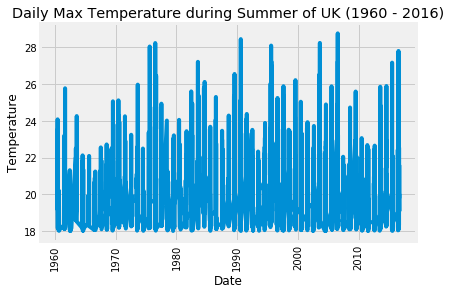

In [14]:
plt.plot(daysabovethresholdtemp.YearMonth, daysabovethresholdtemp.DailyMean)
plt.title('Daily Max Temperature during Summer of UK (1960 - 2016)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.xticks(rotation='vertical')

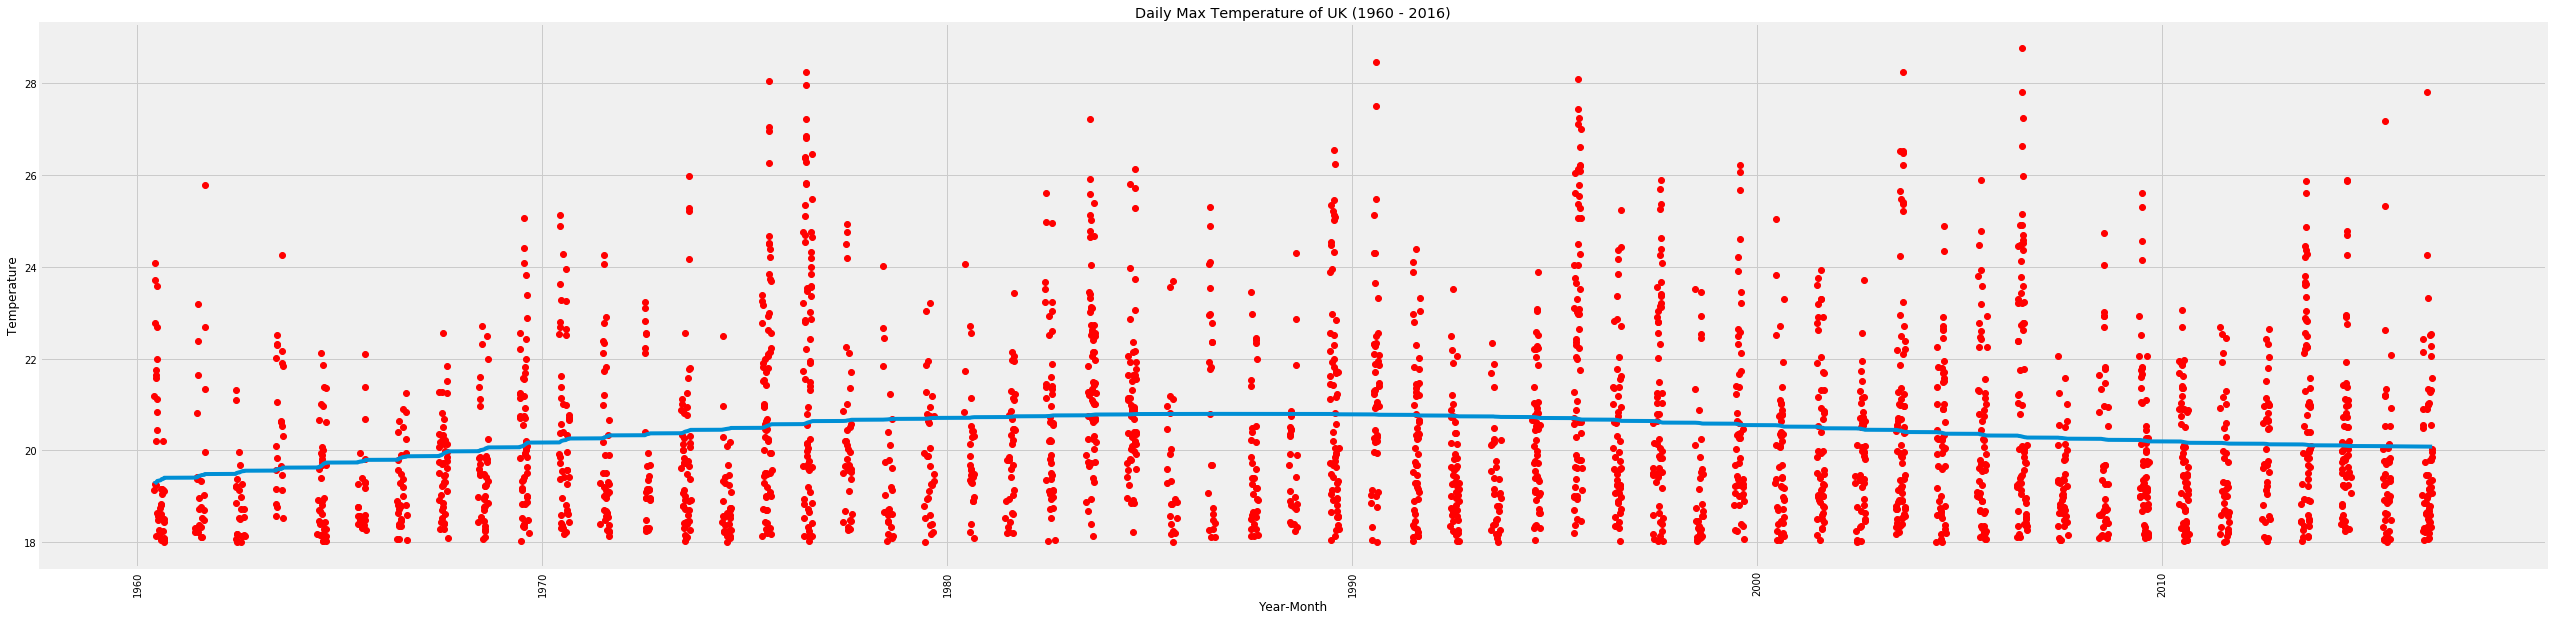

In [15]:
# BEST LINE FIT - the slope of this plot is better (increasing/decreasing) than the previous one
y_values = daysabovethresholdtemp['DailyMean']

#create a set of intervals equal to the number of dates
x_values = np.linspace(0,1,len(daysabovethresholdtemp.loc[:, "DailyMean"]))
poly_degree = 3

coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(x_values)

fig = plt.figure(figsize=(40,10))
plt.xlabel('Year-Month')
plt.title('Daily Max Temperature of UK (1960 - 2016)')
plt.ylabel('Temperature')
plt.xticks(rotation='vertical')
plt.plot(daysabovethresholdtemp.loc[:, "YearMonth"], daysabovethresholdtemp.loc[:,"DailyMean"], "ro")
plt.plot(daysabovethresholdtemp.loc[:, "YearMonth"], y_hat)

In [16]:
# dropping redundant columns that are not required for prediction stage
daysabovethresholdtemp = daysabovethresholdtemp.drop(['Year', 'Month'], axis=1)

In [17]:
# Count the number of days in a year having temp > 18
count = daysabovethresholdtemp['YearMonth'].groupby([daysabovethresholdtemp.YearMonth.dt.year]).agg({'count'}).reset_index()
print(count.dtypes)
print(count.head())
print(count.tail())

YearMonth    int64
count        int64
dtype: object
   YearMonth  count
0       1960     42
1       1961     27
2       1962     25
3       1963     24
4       1964     41
    YearMonth  count
52       2012     38
53       2013     64
54       2014     63
55       2015     46
56       2016     60


In [18]:
# Create a new dataframe with year and count as two columns

newdf = pd.DataFrame(count)
newdf.columns = ['Year','Number_of_days']
print(newdf.dtypes)
print(newdf.head())

Year              int64
Number_of_days    int64
dtype: object
   Year  Number_of_days
0  1960              42
1  1961              27
2  1962              25
3  1963              24
4  1964              41


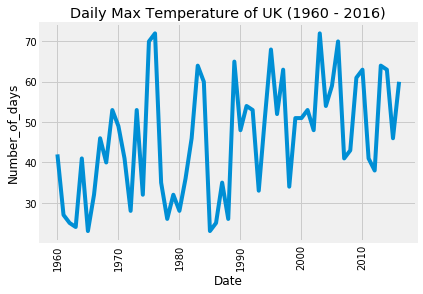

In [35]:
plt.plot(newdf.Year, newdf.Number_of_days)
plt.title('Daily Max Temperature of UK (1960 - 2016)')
plt.xlabel('Date')
plt.ylabel('Number_of_days')
plt.xticks(rotation='vertical')
z=pd.DataFrame(newdf['Year'])
z.insert(1,'Data',newdf['Number_of_days'])
z.to_csv('SGW3.csv', index=False)
# observations from plot: an upward trend is observed denoting increase in number of days with temp > 18

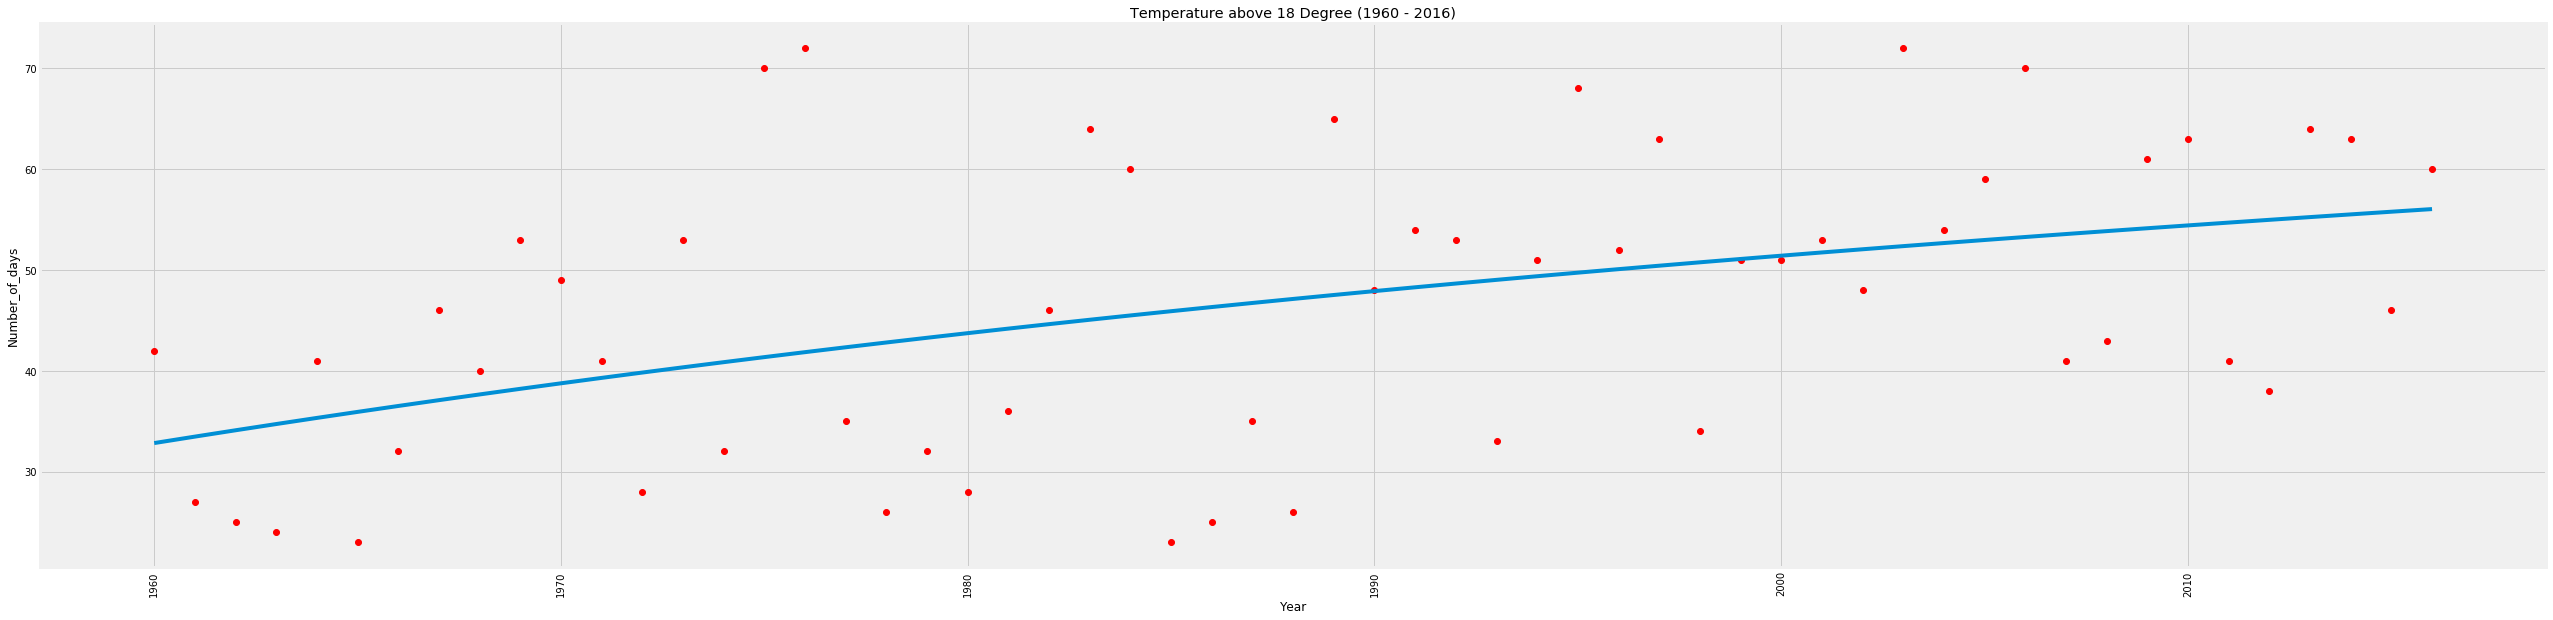

In [36]:
# BEST LINE FIT - to observe the rate of increment in trend of the above plot

y_values = newdf['Number_of_days']

#create a set of intervals equal to the number of dates
x_values = np.linspace(0,1,len(newdf.loc[:, "Number_of_days"]))
poly_degree = 3

coeffs = np.polyfit(x_values, y_values, poly_degree)
poly_eqn = np.poly1d(coeffs)
y_hat = poly_eqn(x_values)
fig = plt.figure(figsize=(40,10))
plt.xlabel('Year')
plt.title('Temperature above 18 Degree (1960 - 2016)')
plt.ylabel('Number_of_days')
plt.xticks(rotation='vertical')
plt.plot(newdf.loc[:, "Year"], newdf.loc[:,"Number_of_days"], "ro")
plt.plot(newdf.loc[:, "Year"], y_hat)
z=pd.DataFrame(y_hat)
z.insert(1,'Year',newdf['Year'])
z.to_csv('SGW4.csv', index=False)
# observations from plot: best line fit confirms an upward trend in the data during summers

In [21]:
# ARIMA MODEL - we make use of arima model to predict the future data
# We are not able to pass the "newdf" pandas dataframe directly to arima model
# so we create a csv and then read it as a pandas dataframe - not ideal (HOW DO WE FIX IT?)

In [22]:
newdf = newdf.astype({"Number_of_days": float})

In [23]:
newdf.to_csv('DaysWithTempAbove18.csv', index=False)

In [24]:
df = pd.read_csv('DaysWithTempAbove18.csv', index_col='Year')
df.index = pd.to_datetime(df.index, format='%Y')
print(df.head())
print(df.dtypes)

            Number_of_days
Year                      
1960-01-01            42.0
1961-01-01            27.0
1962-01-01            25.0
1963-01-01            24.0
1964-01-01            41.0
Number_of_days    float64
dtype: object


In [25]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [26]:
# goal here is to use a “grid search” to find the optimal set of parameters(p, d, q) that yields the best performance for our model.

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(df,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()

        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:595.6294718146287
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:449.9904689412969
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:396.37891210092806
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1285.0780334471356
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:406.7567157321645
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:384.14129732812205
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:287.4366068620436
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1328.0538898759496
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:540.2381389502542
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:412.0231682617816
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:386.4326867698406
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1300.1911779520178
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:406.26211335104654
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:376.19790212395037
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:287.71790952338534
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1357.8080847830101
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:469.033265402191
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:372.14924330082084
A

In [27]:
# ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:270.23857176763033
# the above AIC (Akaike Information Critera) value is the lowest of all, so we should consider its corrosponding values as the optimal

# fitting the arima model

mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1383      0.252      0.548      0.584      -0.356       0.633
ma.L1         -1.0000   1.56e+04  -6.42e-05      1.000   -3.05e+04    3.05e+04
ar.S.L12      -0.5729      0.186     -3.082      0.002      -0.937      -0.209
sigma2       253.5515   3.95e+06   6.42e-05      1.000   -7.74e+06    7.74e+06


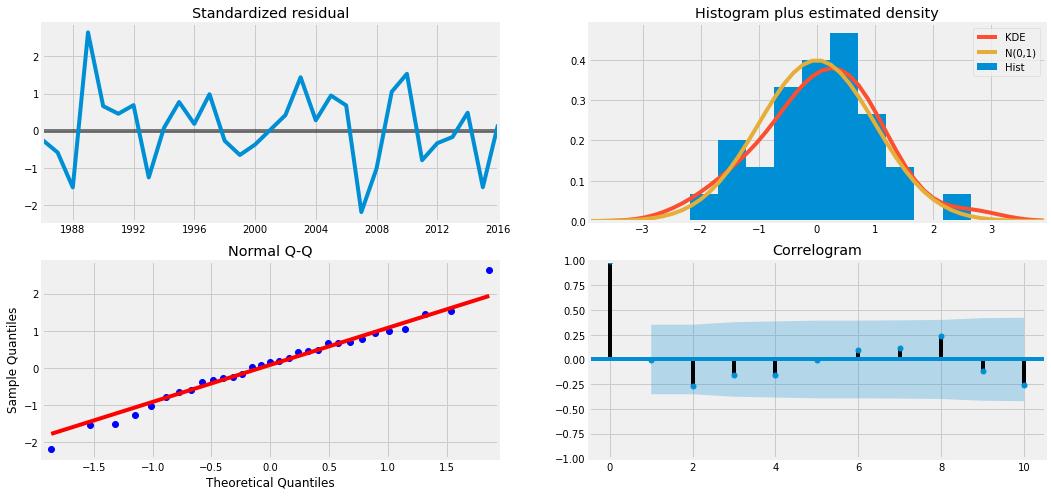

In [28]:
# model diagnostics to investigate any unusual behavior

results.plot_diagnostics(figsize=(16, 8))
plt.show()

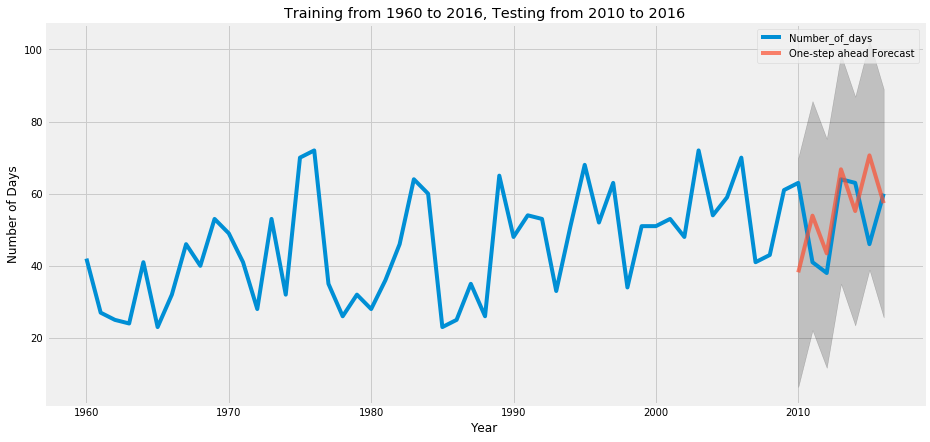

,Number_of_days
Year,
1960-01-01,42.0
1961-01-01,27.0
1962-01-01,25.0
1963-01-01,24.0
1964-01-01,41.0
1965-01-01,23.0
1966-01-01,32.0
1967-01-01,46.0
1968-01-01,40.0


In [39]:
# validating forecasts from 2000-01-01 to the end date 2016-12-01

pred = results.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['1960':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('Training from 1960 to 2016, Testing from 2010 to 2016')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Days')
plt.legend()
plt.show()
df['1960':]
# observations: the predicted plot(orange) is similar to the expected plot(blue)
# the legend is not correct! (HOW DO WE FIX IT?)

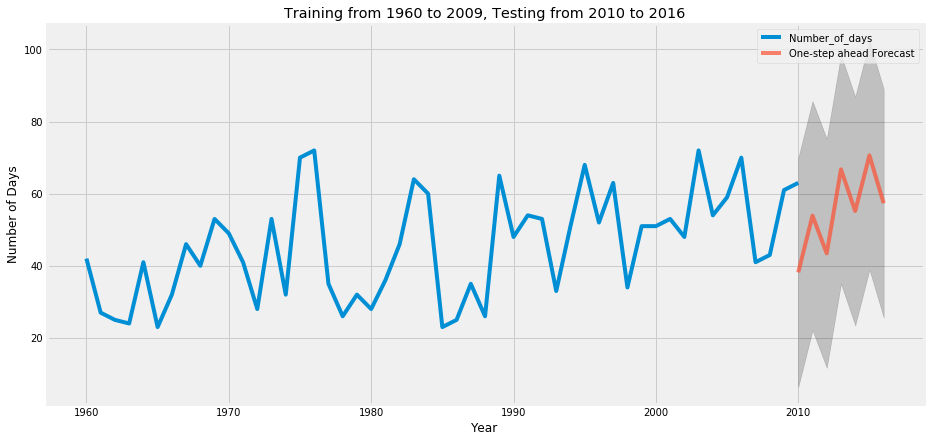

2010-01-01    38.176968
2011-01-01    53.907066
2012-01-01    43.454870
2013-01-01    66.763662
2014-01-01    55.185790
2015-01-01    70.627829
2016-01-01    57.359399
Freq: AS-JAN, dtype: float64

In [38]:
# validating forecasts from 2010-01-01 to the end date 2016-01-01

pred = results.get_prediction(start=pd.to_datetime('2010-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['1960':'2010'].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.title('Training from 1960 to 2009, Testing from 2010 to 2016')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Days')
plt.legend()
plt.show()
pred.predicted_mean

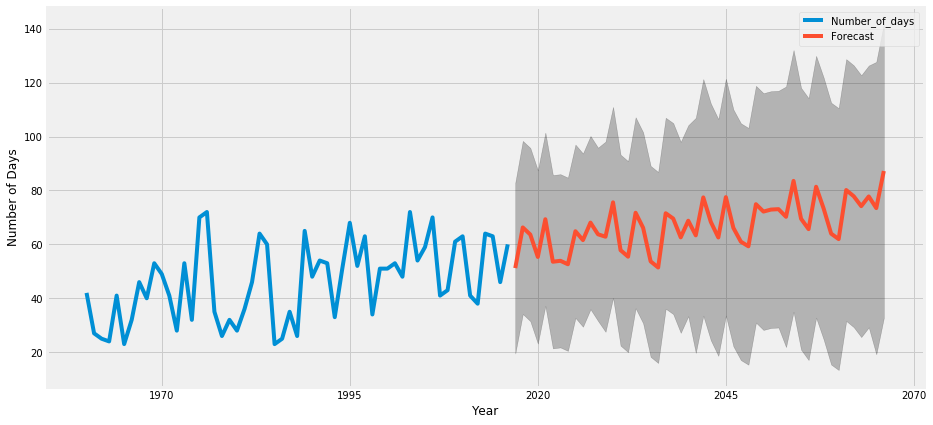

In [31]:
# forecasting data for future 
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Days')
plt.legend()
plt.show()

# observations: the prediction model seems to follow the learned trend and keeps on increasing as expected
# the legend is not correct! (HOW DO WE FIX IT?)

In [32]:
# Extract the predicted and true values of our time series
y_forecasted = pred_uc.predicted_mean
y_truth = df['2010-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# the results are NaN - why?

The Mean Squared Error of our forecasts is 2017-01-01 00:00:00   NaN
2018-01-01 00:00:00   NaN
2019-01-01 00:00:00   NaN
2020-01-01 00:00:00   NaN
2021-01-01 00:00:00   NaN
2022-01-01 00:00:00   NaN
2023-01-01 00:00:00   NaN
2024-01-01 00:00:00   NaN
2025-01-01 00:00:00   NaN
2026-01-01 00:00:00   NaN
2027-01-01 00:00:00   NaN
2028-01-01 00:00:00   NaN
2029-01-01 00:00:00   NaN
2030-01-01 00:00:00   NaN
2031-01-01 00:00:00   NaN
2032-01-01 00:00:00   NaN
2033-01-01 00:00:00   NaN
2034-01-01 00:00:00   NaN
2035-01-01 00:00:00   NaN
2036-01-01 00:00:00   NaN
2037-01-01 00:00:00   NaN
2038-01-01 00:00:00   NaN
2039-01-01 00:00:00   NaN
2040-01-01 00:00:00   NaN
2041-01-01 00:00:00   NaN
2042-01-01 00:00:00   NaN
2043-01-01 00:00:00   NaN
2044-01-01 00:00:00   NaN
2045-01-01 00:00:00   NaN
2046-01-01 00:00:00   NaN
2047-01-01 00:00:00   NaN
2048-01-01 00:00:00   NaN
2049-01-01 00:00:00   NaN
2050-01-01 00:00:00   NaN
2051-01-01 00:00:00   NaN
2052-01-01 00:00:00   NaN
2053-01-01 00:00:00  

In [33]:
print(df[1,1])

KeyError: (1, 1)

In [34]:
print(pred_uc.predicted_mean)

2017-01-01    51.196271
2018-01-01    66.278131
2019-01-01    63.640538
2020-01-01    55.330067
2021-01-01    69.320096
2022-01-01    53.560837
2023-01-01    53.903167
2024-01-01    52.621808
2025-01-01    64.872684
2026-01-01    61.581163
2027-01-01    68.069251
2028-01-01    63.737085
2029-01-01    62.841239
2030-01-01    75.584682
2031-01-01    57.844589
2032-01-01    55.440782
2033-01-01    71.728044
2034-01-01    66.142712
2035-01-01    53.685564
2036-01-01    51.419630
2037-01-01    71.547107
2038-01-01    69.568353
2039-01-01    62.600580
2040-01-01    68.770549
2041-01-01    63.344433
2042-01-01    77.427509
2043-01-01    68.339339
2044-01-01    62.551722
2045-01-01    77.522944
2046-01-01    66.109171
2047-01-01    60.984591
2048-01-01    59.282700
2049-01-01    74.897828
2050-01-01    72.167016
2051-01-01    72.907839
2052-01-01    73.061343
2053-01-01    70.230529
2054-01-01    83.546156
2055-01-01    69.501471
2056-01-01    65.652371
2057-01-01    81.377527
2058-01-01    73